<a href="https://colab.research.google.com/github/bieenr/MediaOneOOP/blob/main/Unet_satelite_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/gdrive/MyDrive/bkai_naver/segment_data_public.zip","r") as z:
    z.extractall()
    z.close()

In [ ]:
import logging
import os 
from os import listdir
from os.path import splitext
from pathlib import Path
import cv2 
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset


class BasicDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str, scale: float = 1.0, mask_suffix: str = '', transform = None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix
        self.transform = transform 
        self.ids = [splitext(file)[0] for file in listdir(images_dir) if not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(pil_img, scale, is_mask):
        w, h = pil_img.shape
        #print(pil_img)
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'

        img_ndarray = cv2.resize(pil_img,(newW, newH))
        #print(img_ndarray.shape)
            


        if not is_mask:
            
            img_ndarray = img_ndarray / 255

            total_sum = 0
            total_sum += img_ndarray.sum()
            mean = total_sum / (256*256*1)
            sum_of_squared_error = 0
            sum_of_squared_error += np.power((img_ndarray - mean),2).sum()
            Sum_of_squared_error = torch.tensor(sum_of_squared_error)
            std = torch.sqrt(Sum_of_squared_error / (256*256*1))
            img_ndarray = (img_ndarray - mean)/ std
        if is_mask:
            img_ndarray = img_ndarray / 255

        IMG_ndarray  = np.asarray(img_ndarray)


        return IMG_ndarray

    @staticmethod
    def load(filename):
        array = cv2.imread(filename,0)
        #dst = cv2.Laplacian(src_gray, cv2.CV_16S, ksize=3)
        #print(array.size)
        return array

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.masks_dir.glob(name + self.mask_suffix + '.png'))
        img_file = list(self.images_dir.glob(name + '.png'))

        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        mask = self.load(os.path.join(self.images_dir,mask_file[0]))
        img = self.load(os.path.join(self.images_dir,img_file[0]))
        dst = cv2.Laplacian(img, cv2.CV_16S, ksize=3)
        abs_dst = cv2.convertScaleAbs(dst)
        #cv2_imshow(abs_dst)
        #print(dst)

        assert img.size == mask.size, \
            'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(abs_dst, self.scale, is_mask=False)
        mask = self.preprocess(mask, self.scale, is_mask=True)
        #print(type(mask))
        #masks = np.trunc(mask)
        masks = torch.as_tensor(mask.copy())
        masks = (masks > 0.5).float()

        
        return {
            'image_name':name + '.png',
            'image': torch.as_tensor(img).float().contiguous(),
            'mask': masks.long().contiguous()
        }

In [ ]:
from google.colab.patches import cv2_imshow

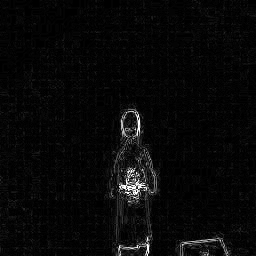

tensor([[-0.3964, -0.2074, -0.2074,  ..., -0.3964, -0.3964, -0.3964],
        [-0.2074, -0.3964, -0.2074,  ..., -0.3964, -0.3964, -0.3964],
        [-0.0184, -0.2074, -0.2074,  ..., -0.3964, -0.3964, -0.3964],
        ...,
        [-0.0184, -0.1129,  0.0761,  ..., -0.2074, -0.1129,  0.1706],
        [-0.0184, -0.2074, -0.3019,  ..., -0.3964, -0.3019, -0.0184],
        [-0.3964, -0.0184, -0.2074,  ...,  0.3596,  0.3596,  0.3596]])
torch.Size([256, 256])


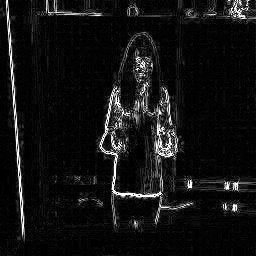

tensor([[ 0.1277, -0.0613, -0.4393,  ..., -0.3448, -0.3448,  1.2618],
        [ 0.0332, -0.0613, -0.3448,  ..., -0.2975,  0.4113, -0.1558],
        [-0.1558, -0.0613, -0.3448,  ..., -0.1085, -0.0613,  0.1277],
        ...,
        [-0.2503, -0.1558, -0.2030,  ..., -0.3448, -0.3448, -0.2503],
        [-0.1558, -0.3448, -0.2503,  ..., -0.2975, -0.3448, -0.1558],
        [-0.0613, -0.3448, -0.3448,  ..., -0.4393, -0.3448, -0.4393]])
torch.Size([256, 256])


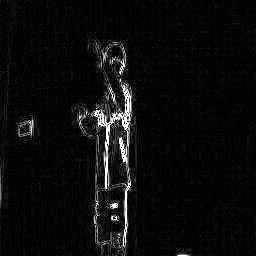

tensor([[ 0.1319,  0.0125,  0.0125,  ..., -0.3455, -0.3455, -0.1068],
        [ 0.3706, -0.2858, -0.1665,  ..., -0.2858, -0.2858, -0.1068],
        [ 0.2513, -0.3455, -0.2858,  ..., -0.2858, -0.2858, -0.2262],
        ...,
        [ 0.0125, -0.1068, -0.2262,  ..., -0.3455, -0.3455, -0.2262],
        [-0.1068, -0.2262, -0.3455,  ..., -0.1665, -0.3455, -0.1068],
        [-0.1068, -0.2262, -0.3455,  ..., -0.2262, -0.2262, -0.1068]])
torch.Size([256, 256])


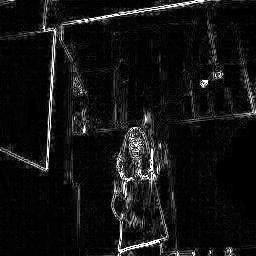

tensor([[ 0.9549,  0.9549,  0.9549,  ...,  0.3395,  0.2370,  0.1344],
        [ 0.4421,  0.6472,  1.1600,  ..., -0.3270, -0.3783, -0.1732],
        [ 1.5702,  1.3651,  1.2625,  ..., -0.1732, -0.2245,  0.0319],
        ...,
        [-0.3783, -0.3783, -0.3783,  ..., -0.4296, -0.4296, -0.4809],
        [-0.3783, -0.3783, -0.3783,  ..., -0.4296, -0.3783, -0.3783],
        [-0.4809, -0.4809, -0.4809,  ..., -0.4809, -0.4809, -0.4809]])
torch.Size([256, 256])


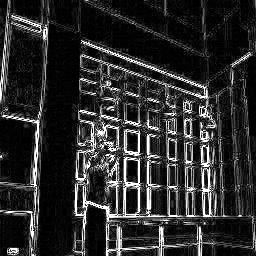

tensor([[-0.5564, -0.5564, -0.5564,  ..., -0.1262, -0.1262,  1.1643],
        [-0.6179, -0.6179, -0.6179,  ..., -0.1262, -0.1570,  1.1643],
        [-0.6179, -0.6179, -0.6179,  ..., -0.2184, -0.1570,  1.1028],
        ...,
        [-0.4950, -0.5564, -0.5257,  ..., -0.4335, -0.5257, -0.1877],
        [-0.6179, -0.4950, -0.5257,  ..., -0.3721, -0.5564, -0.2492],
        [-0.5564, -0.4950, -0.4335,  ..., -0.6179, -0.1262, -0.6793]])
torch.Size([256, 256])


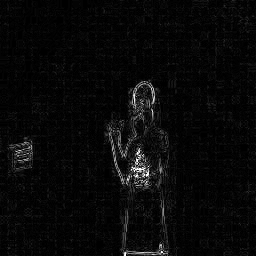

tensor([[-0.0447, -0.2540, -0.2540,  ...,  0.1645, -0.0447, -0.4632],
        [-0.4632, -0.3586, -0.2540,  ..., -0.2540, -0.3586, -0.2540],
        [-0.2540, -0.2540, -0.3586,  ..., -0.2540, -0.2540, -0.2540],
        ...,
        [-0.2540, -0.3586, -0.2540,  ..., -0.3586, -0.3586, -0.0447],
        [-0.2540, -0.4632, -0.2540,  ..., -0.0447, -0.3586, -0.2540],
        [-0.0447, -0.2540, -0.0447,  ...,  0.3738, -0.2540, -0.4632]])
torch.Size([256, 256])


In [ ]:

Train = BasicDataset("/content/segment_data/image","/content/segment_data/mask")
for batch_idx,x in enumerate(Train):
  print(x["image"].float())
  print(x["image"].shape)
  if (batch_idx == 5): 
    break



In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
MODEL = UNET(1,1)
if torch.cuda.is_available():
    MODEL.cuda()

In [ ]:
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

import logging
import os
from os import listdir
from os.path import splitext
from pathlib import Path

import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset

#import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torchvision.transforms import ToTensor

In [ ]:

batch_size = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = optim.Adam(MODEL.parameters(), lr= 1e-4)
loss_fn = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

In [ ]:
from typing import no_type_check
import torch
import torchvision
#from dataset import CarvanaDataset
from torch.utils.data import DataLoader
from sklearn.metrics import jaccard_score

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    #val_dir,
    #val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = BasicDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )
    return train_loader #, val_loader
"""
    val_ds = BasicDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )
"""


def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for M in loader:
            x = M["image"]
            y = M["mask"]
            x = x.to(device).unsqueeze(1)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()


            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()



def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, M in enumerate(loader):
        z = M['image_name']
        kp = z[0].split(".")
        nk = kp[0]
        x = M["image"].unsqueeze(1)
        y = M["mask"]
        y = y.to(device=device)
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            #preds = preds.long()
            #print(preds)
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{nk}.png"
        )
        torchvision.utils.save_image(y.float().unsqueeze(1), f"{folder}/{nk}.png")

    model.train()

def check_accuracy_iou(loader,model,device ='cuda'):
    
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for M in loader:
            x = M["image"]
            y = M["mask"]
            x = x.to(device).unsqueeze(1)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            # iou = IoU(num_classes=2)
            # z = iou(pred, y)
            pred = preds.cpu().numpy().flatten()
            yy = y.cpu().numpy().flatten()
            z = jaccard_score(pred, yy)
            iou_score = iou_score + z
            

    print(f"Dice score: {iou_score/len(loader)}")
    model.train()

In [ ]:

dataset = BasicDataset("/content/segment_data/image","/content/segment_data/mask")
n_val = int(len(dataset) * 0.1)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader =   DataLoader(val_set, shuffle=True, **loader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torch.cuda import device
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, x in enumerate(loop):
        data = x["image"].unsqueeze(1)
        targets = x["mask"]
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data) #torch.sigmoid(model(data))
            loss = loss_fn( predictions,targets)
            #print(loss)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [ ]:
#check_accuracy(val_loader, model, device=DEVICE)
import gc 
if 0:
  load_checkpoint(torch.load("/content/my_checkpoint.pth.tar"), MODEL)

for epoch in range(3):

        #del variables
        gc.collect()
        train_fn(train_loader,MODEL, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": MODEL.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy_iou(val_loader, MODEL, device=DEVICE)

        # print some examples to a folder
        """
        save_predictions_as_imgs(
            val_loader,MODEL, folder="saved_images/", device=DEVICE
        )
        """

  0%|          | 0/283 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 283/283 [05:26<00:00,  1.15s/it, loss=0.0495]


=> Saving checkpoint
Dice score: 0.9476103287812708


  0%|          | 0/283 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 283/283 [05:25<00:00,  1.15s/it, loss=0.0268]


=> Saving checkpoint
Dice score: 0.9590242628320498


  0%|          | 0/283 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 283/283 [05:26<00:00,  1.15s/it, loss=0.025]


=> Saving checkpoint
Dice score: 0.9566287156862379


In [ ]:
if 1:
  load_checkpoint(torch.load("/content/gdrive/MyDrive/bkai_naver/my_checkpoint.pth (7).tar"), MODEL)

=> Loading checkpoint


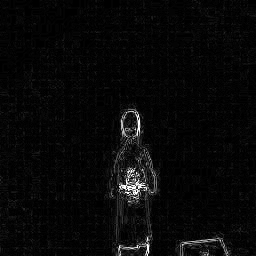

(256, 256)


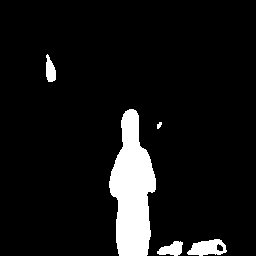

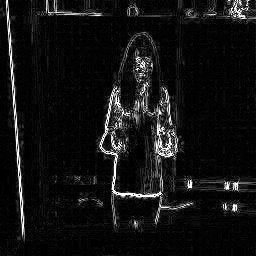

(256, 256)


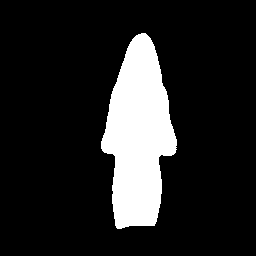

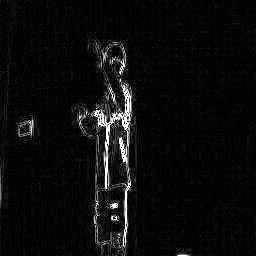

(256, 256)


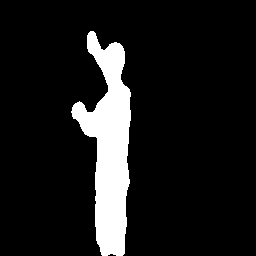

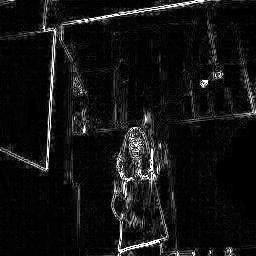

(256, 256)


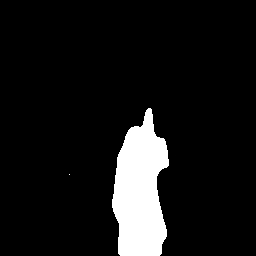

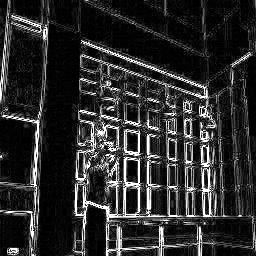

(256, 256)


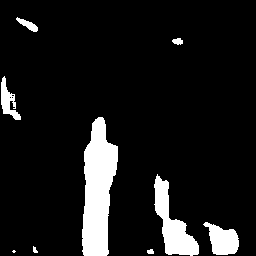

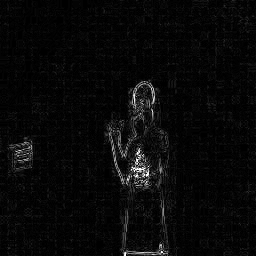

(256, 256)


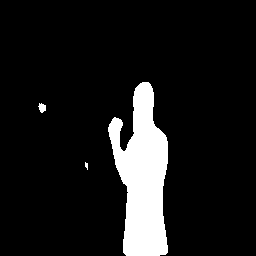

In [ ]:
for batch_idx,x in enumerate(Train):
  predict = x["image"].unsqueeze(0).unsqueeze(0)
  predict = predict.to(device="cuda")
  with torch.no_grad():
    preds = torch.sigmoid(MODEL(predict))
    preds = (preds > 0.5).float()
    pred = preds.cpu().numpy().squeeze()
    print(pred.shape)
    pred = pred * 255
    cv2_imshow(pred)
  if (batch_idx == 5): 
    break

In [ ]:
os.makedirs("/content/saved_images/")
save_predictions_as_imgs(
            val_loader,MODEL, folder="saved_images/", device=DEVICE
        )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#Test

In [ ]:
import zipfile
with zipfile.ZipFile("/content/gdrive/MyDrive/bkai_naver/public_test_segment_data.zip","r") as z:
    z.extractall()
    z.close()

In [ ]:
# Run-Length Encode and Decode

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def rle_encode_copy(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return runs
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)
"""
# Time Test
masks = pd.read_csv('../input/train_masks.csv')
num_masks = masks.shape[0]
print('Total masks to encode/decode =', num_masks)

time_enc = 0.0 # seconds
time_dec = 0.0 # seconds

for r in masks.itertuples():
    t0 = time.clock()
    mask = rle_decode(r.rle_mask,(1280,1918))
    time_dec += time.clock() - t0
    t0 = time.clock()   
    mask_rle = rle_encode(mask)
    time_enc += time.clock() - t0
    #assert (mask_rle == r.rle_mask)

print('Time full encoding = {:.4f} ms per mask'.format(1000*time_enc/num_masks))
print('Time full decoding = {:.4f} ms per mask'.format(1000*time_dec/num_masks))
"""

"\n# Time Test\nmasks = pd.read_csv('../input/train_masks.csv')\nnum_masks = masks.shape[0]\nprint('Total masks to encode/decode =', num_masks)\n\ntime_enc = 0.0 # seconds\ntime_dec = 0.0 # seconds\n\nfor r in masks.itertuples():\n    t0 = time.clock()\n    mask = rle_decode(r.rle_mask,(1280,1918))\n    time_dec += time.clock() - t0\n    t0 = time.clock()   \n    mask_rle = rle_encode(mask)\n    time_enc += time.clock() - t0\n    #assert (mask_rle == r.rle_mask)\n\nprint('Time full encoding = {:.4f} ms per mask'.format(1000*time_enc/num_masks))\nprint('Time full decoding = {:.4f} ms per mask'.format(1000*time_dec/num_masks))\n"

In [ ]:
import logging
import os 
from os import listdir
from os.path import splitext
from pathlib import Path
import cv2 
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset


class TestDataset(Dataset):
    def __init__(self, images_dir: str, scale: float = 1.0):
        self.images_dir = Path(images_dir)
        
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale 
        self.ids = [splitext(file)[0] for file in listdir(images_dir) if not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(pil_img, scale, is_mask):
        w, h = pil_img.shape
        #print(pil_img)
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'

        img_ndarray = cv2.resize(pil_img,(newW, newH))
        #print(img_ndarray.shape)
            


        if not is_mask:
            
            img_ndarray = img_ndarray / 255

            total_sum = 0
            total_sum += img_ndarray.sum()
            mean = total_sum / (256*256*1)
            sum_of_squared_error = 0
            sum_of_squared_error += np.power((img_ndarray - mean),2).sum()
            Sum_of_squared_error = torch.tensor(sum_of_squared_error)
            std = torch.sqrt(Sum_of_squared_error / (256*256*1))
            img_ndarray = (img_ndarray - mean)/ std
        if is_mask:
            img_ndarray = img_ndarray / 255

        IMG_ndarray  = np.asarray(img_ndarray)


        return IMG_ndarray

    @staticmethod
    def load(filename):
        array = cv2.imread(filename,0)
        #dst = cv2.Laplacian(src_gray, cv2.CV_16S, ksize=3)
        #print(array.size)
        return array

    def __getitem__(self, idx):
        name = self.ids[idx]
        
        img_file = list(self.images_dir.glob(name + '.png'))

        
        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        
        img = self.load(os.path.join(self.images_dir,img_file[0]))
        dst = cv2.Laplacian(img, cv2.CV_16S, ksize=3)
        abs_dst = cv2.convertScaleAbs(dst)
        #print(dst)



        img = self.preprocess(abs_dst, self.scale, is_mask=False)

        #print(type(mask))
        #masks = np.trunc(mask)


        
        return {
            'image': torch.as_tensor(img).float().contiguous(),
            'image_name': name + '.png',
            "idx" :self.ids
        }

In [ ]:
TestData = TestDataset("/content/public_test_segment_data/image")
loader_args_test = dict(batch_size=1, num_workers=4, pin_memory=True)
test_loader = DataLoader(TestData, shuffle=False, **loader_args_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
tag = []
filename = []
encode_mask = []
for i in TestData:
  p = i["image"].to(device = "cuda" if torch.cuda.is_available() else "cpu")
  p = p.unsqueeze(0).unsqueeze(0).float()


  preds = torch.sigmoid(MODEL(p))

  preds = (preds > 0.5).float()
  pred = preds.cpu().numpy()
  x = rle_encode(pred)
  #print(type(x))
  #print(x.shape)
  #print(x)
  tag.append(0)
  filename.append(i["image_name"])
  encode_mask.append(x)

df = pd.DataFrame({'tag': tag ,
                   'filename': filename ,
                   'encode_mask': encode_mask})
compression_opts = dict(method='zip',
                        archive_name='results.csv')  
df.to_csv('results.zip', index=False,header = False,
          compression=compression_opts)